# 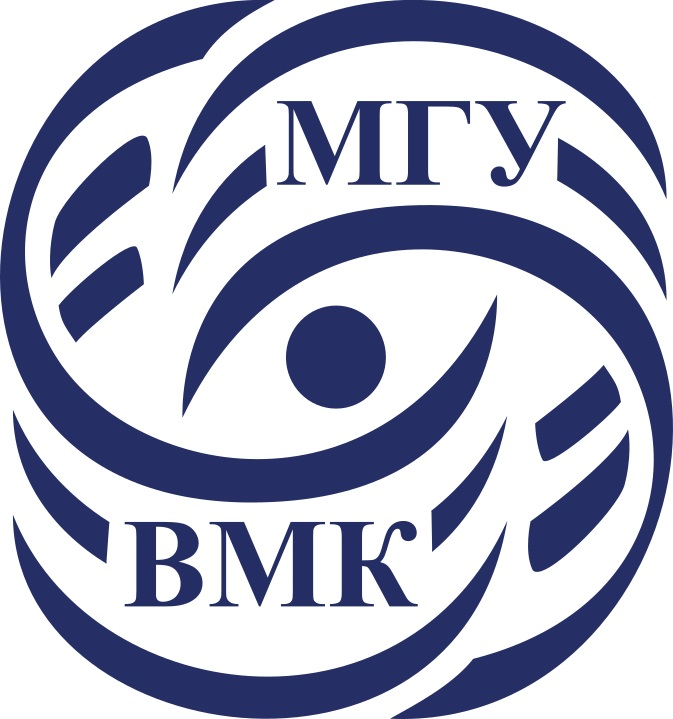

# Машинное обучение. ВМК МГУ

# Практическое задание 7: SVM
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)

-------
<font color="white" style="opacity:0.2025"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [79]:
! curl https://raw.githubusercontent.com/MSU-ML-COURSE/ML-COURSE-25-26/refs/heads/master/requirements/requirements.txt -o ./requirements_2025_26_for_colab_small.txt
! pip install -q -r ./requirements_2025_26_for_colab_small.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   360  100   360    0     0    860      0 --:--:-- --:--:-- --:--:--   865

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Проверим версию библиотеки:

In [80]:
import catboost
assert(catboost.__version__ == '1.2.8')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2025"></font>

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

Приведем вспомогательный код

In [82]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [83]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [84]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# Загрузка данных

In [85]:
# import gdown
# gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

# SVM и разделяющая поверхность

На лекции вы изучили, что линейная, с виду, модель SVM, при помощи некоторых "фокусов", называемых ядрами, умеет строить нелинейные поверхности. В данном ноутбуке посмотрим, как это все работает на практике, и какие гиперпараметры настройки у этого метода есть.

<font color='MediumTurquoise'>**Историческая справка:**</font> Метод опорных векторов (SVM) стал популярным в 90-х годах, особенно с 1995 года, благодаря своей эффективности в задачах классификации и способности обрабатывать высокоразмерные данные. Он также привлек внимание благодаря использованию ядровых функций, что позволяло решать нелинейные задачи. Однако с появлением более сложных методов, таких как глубокое обучение, и увеличением объема данных, SVM стал менее популярным, поскольку более современные алгоритмы демонстрировали лучшие результаты на больших наборах данных и обеспечивали более простую настройку.

## <font color='DarkOrange'>**Задание 1 [1 балл]**</font>


В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.


    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью ```sklearn.svm.SVC(kernel='linear')```, а также нелинейную c rbf-ядром с помощью ```sklearn.svm.SVC(kernel='rbf')```. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [86]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

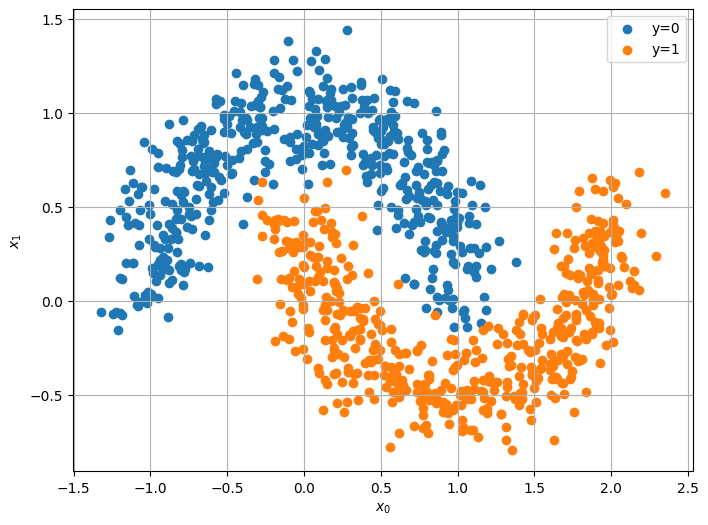

In [87]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

In [88]:
linear_svc.fit(X, y)
nonlinear_svc.fit(X, y)

SVC()

In [89]:
# Your code here
print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')

Train Accuracy (linear): 0.885


In [90]:
# Your code here
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

Train Accuracy (non linear): 0.990


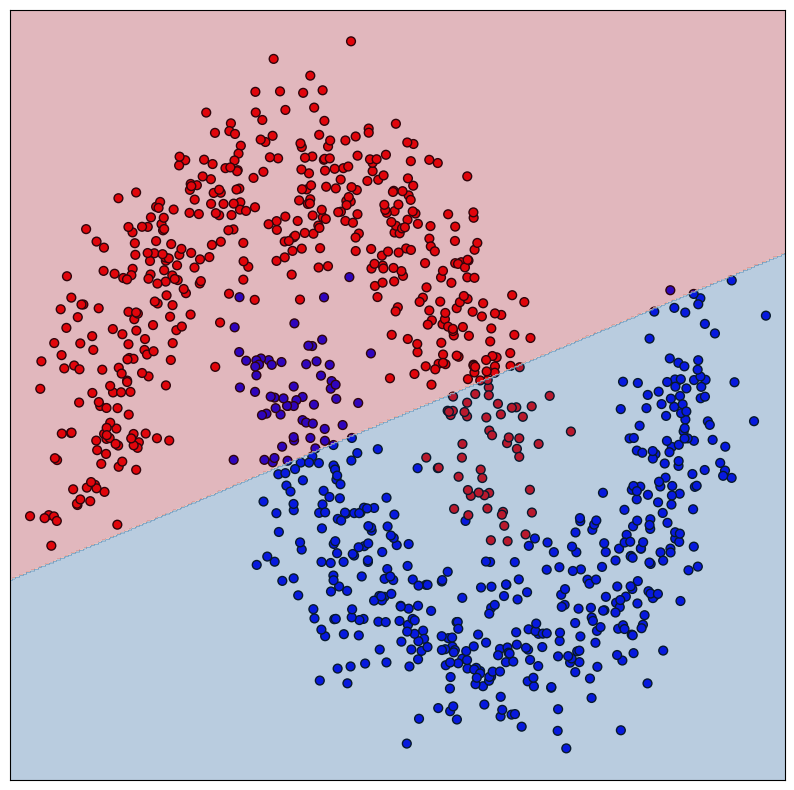

In [91]:
plot_separating_surface(X, y, linear_svc)

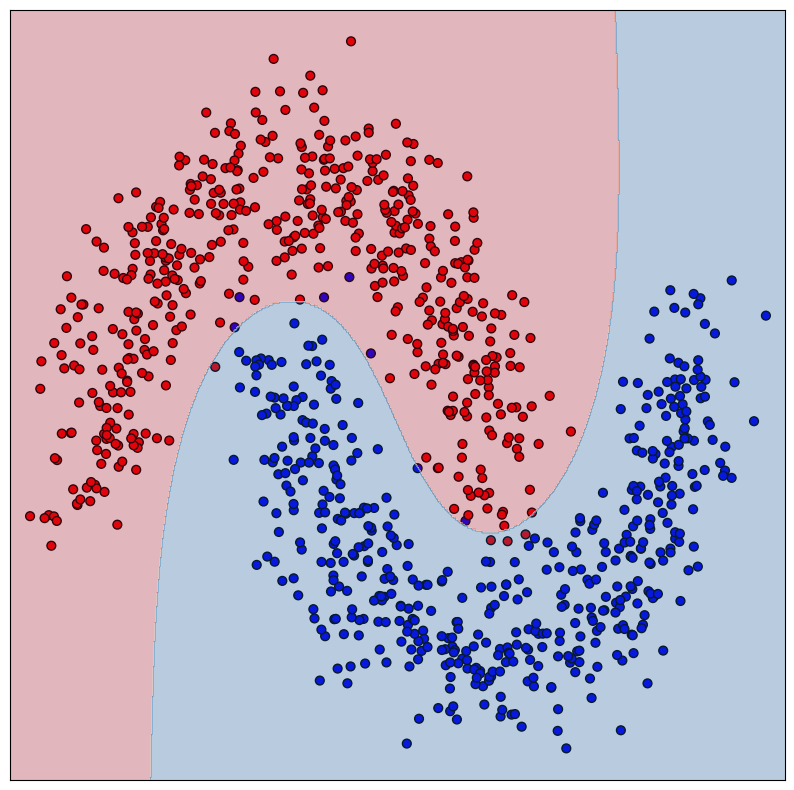

In [92]:
plot_separating_surface(X, y, nonlinear_svc)

**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему?

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Качество классификации при применении нелинейного ядра намного выше, чем при линейной, потому что сами данные нелинейные. Для данных, описываемых нелинейными законами, лучше использовать нелинейный классификатор.

## 2. Опорные объекты

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

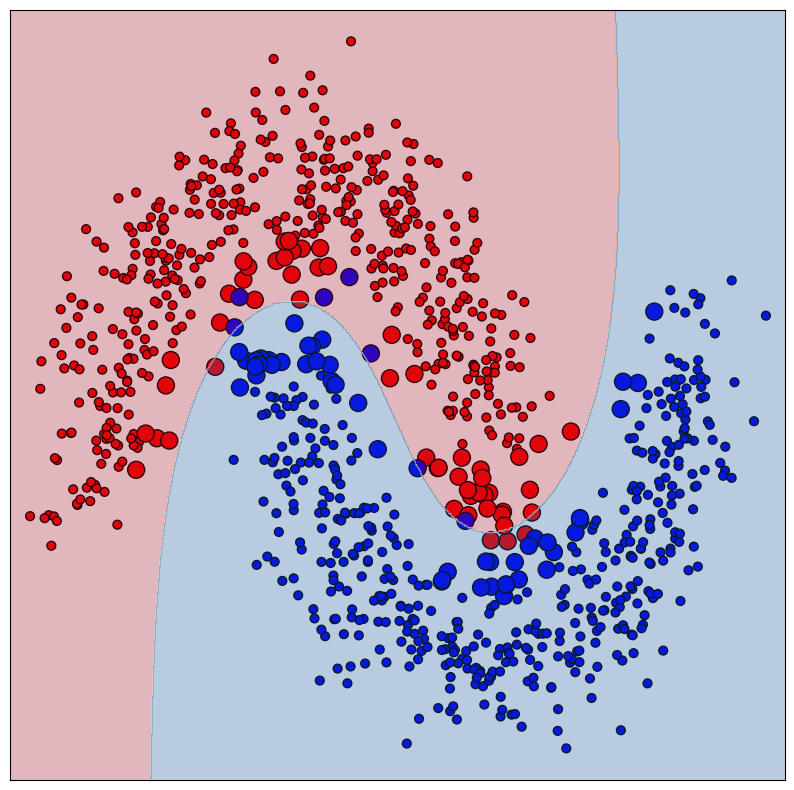

In [93]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

Обучим новые две модели ```SVC(kernel='rbf')```, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [94]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

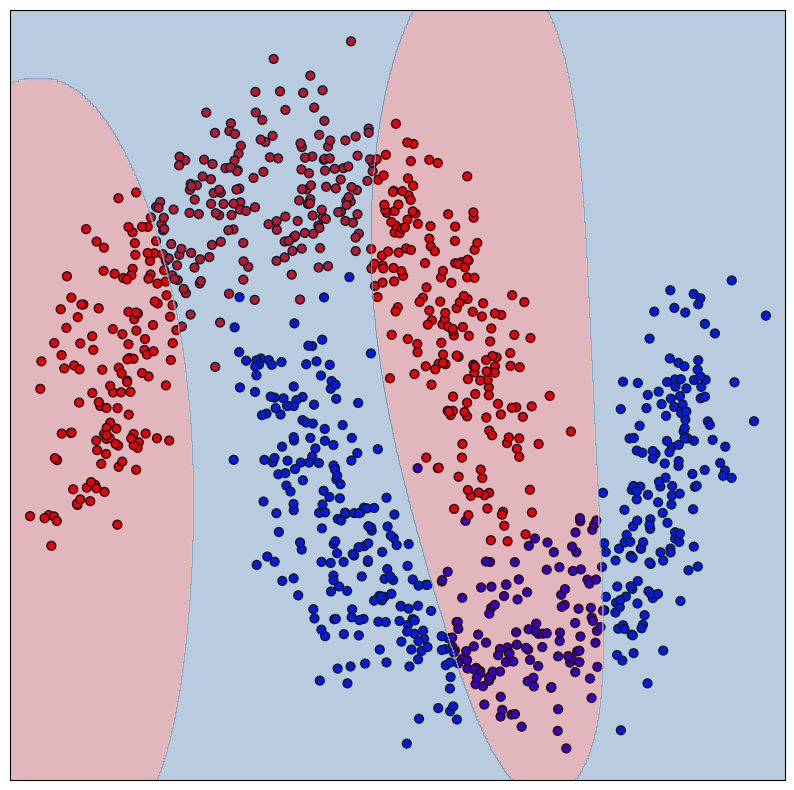

In [95]:
plot_separating_surface(X, y, svc_on_linear_support)

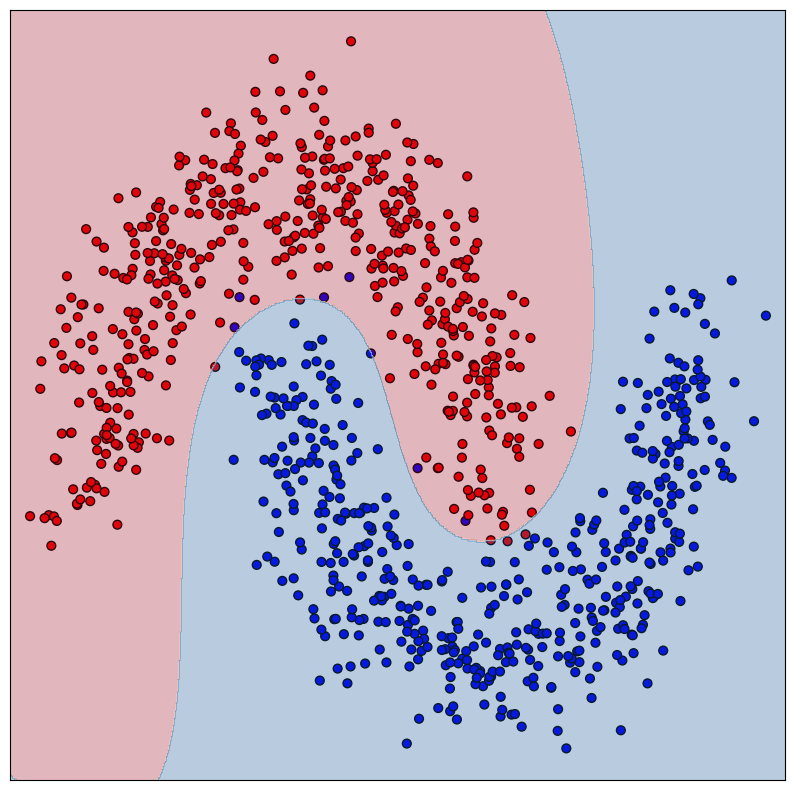

In [96]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 2 [1 балл]**</font>

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из задания 1. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе.


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Для начала посмотрим, на то, какие объекты были опорными для линейной модели

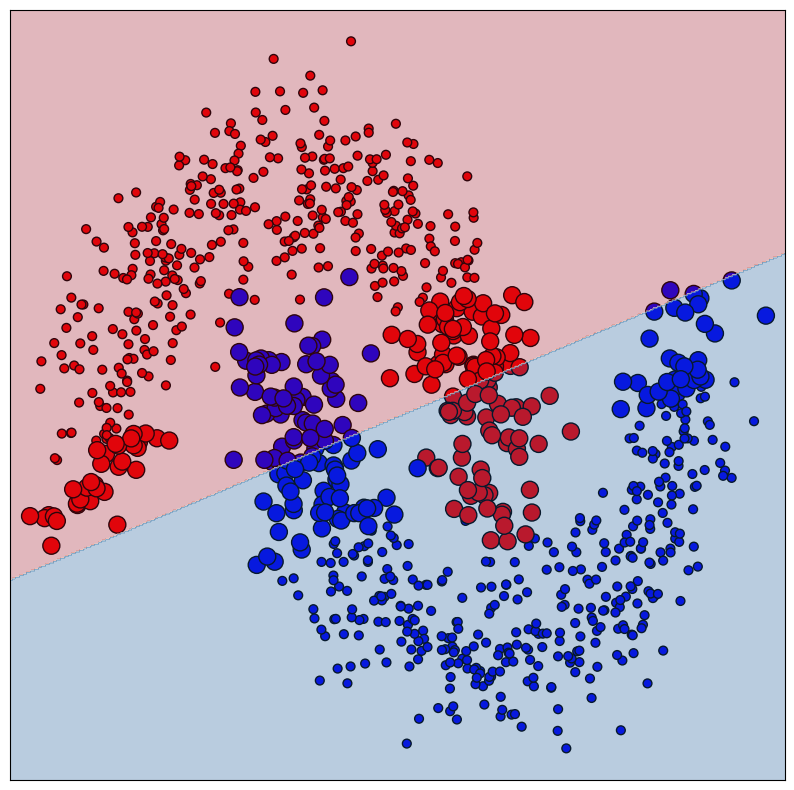

In [97]:
plot_separating_surface(X, y, linear_svc, view_support=True)

Нетрудно видеть, что разделяющая поверхность модели, обученной на опорных векторах нелинейной модели имеет почти такую же разделяющую поверхность, что и модель, обученная на всей выборке, в то время как модель, обученная на опорных векторах линейной модели, строит вообще непохожие поверхности. Почему так происходит легко понять, взглянув на опорные вектора, для линейной модели они сосредоточены у линейной границы, а не у настоящей разделяющей поверхности, в то время как у нелинейной модели опорные вектора находятся у настоящей нелинейной границы между множествами.

---

Теперь обучим модель ```SVC(kernel='rbf')```, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из задания 1(nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [98]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

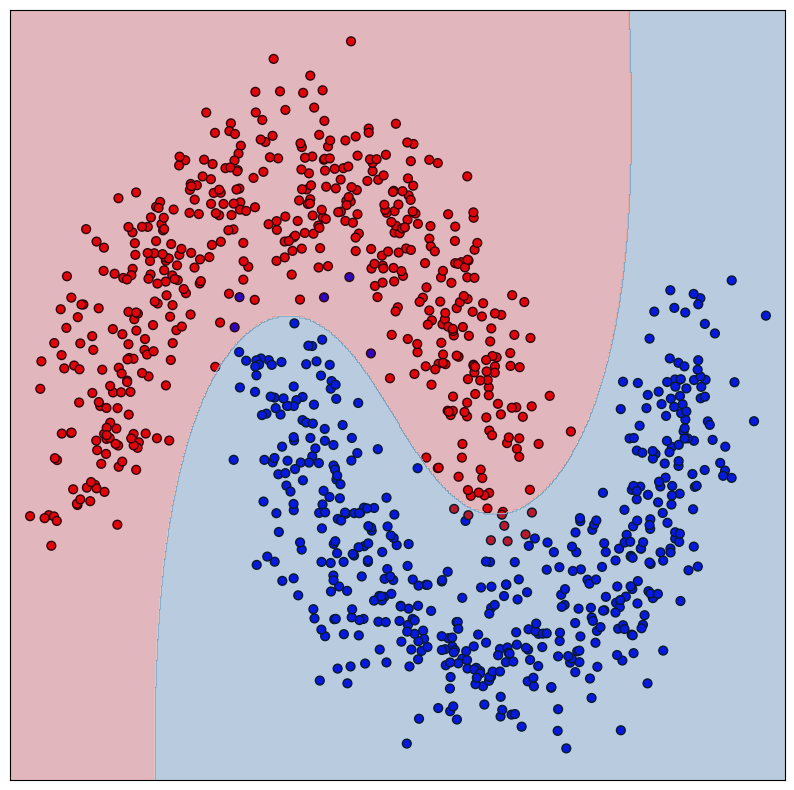

In [99]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

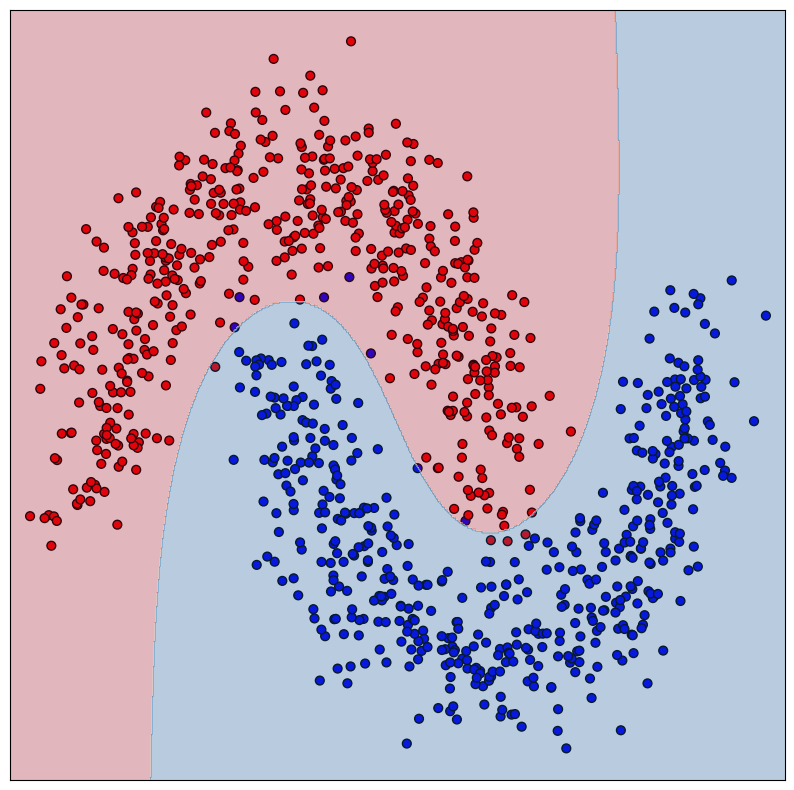

In [100]:
plot_separating_surface(X, y, nonlinear_svc)

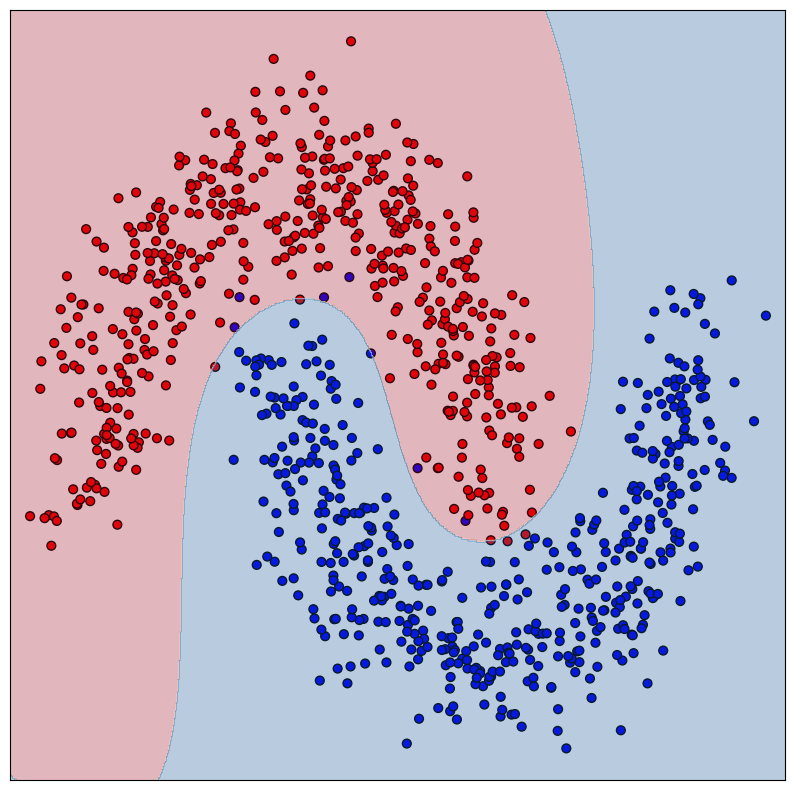

In [101]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 3 [1.5 баллa]**</font>

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первом задании? Что произошло с пограничными объектами? Объясните полученные результаты.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Полученная разделяющая поверхность почти не отличается от поверхностей, полученных предыдущими моделями, так как выборка избыточна и опорные вектора составляют малую её часть. Но так как опобрные вектора находились на границе, то точность предсказаний на границе уменьшилась, теперь разделяющая поверхность хуже подстраивается под объекты на границе.

# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения.
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :)

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [102]:
X_train = np.load('05-SVM/public/cX_train.npy')
y_train = np.load('05-SVM/public/cy_train.npy')
X_test = np.load('05-SVM/public/cX_test.npy')

In [103]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [104]:
X = X_train
y = y_train.ravel()

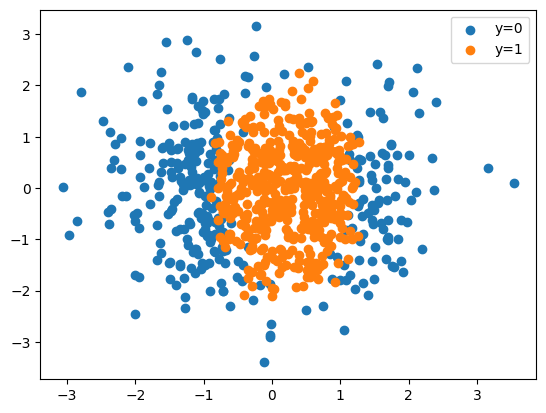

In [105]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [107]:
params = {
    'scaler' : (None, StandardScaler(), MinMaxScaler()),
    'estimator__kernel' : ('rbf', 'sigmoid', 'linear'),
    # 'estimator__degree' : (2, 3, 4),
    'estimator__C' : (0.01, 0.1, 1, 10, 100, 1000)
}

pipe = Pipeline([
    ['scaler', StandardScaler()],
    # ['poly', PolynomialFeatures(1)],
    ['estimator', SVC(kernel='rbf')]
])

In [108]:
clf = GridSearchCV(pipe, params)

In [109]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[['scaler', StandardScaler()],
                                       ['estimator', SVC()]]),
             param_grid={'estimator__C': (0.01, 0.1, 1, 10, 100, 1000),
                         'estimator__kernel': ('rbf', 'sigmoid', 'linear'),
                         'scaler': (None, StandardScaler(), MinMaxScaler())})

In [110]:
for elem in zip (clf.cv_results_['params'], clf.cv_results_['mean_test_score']):
  print(elem)

({'estimator__C': 0.01, 'estimator__kernel': 'rbf', 'scaler': None}, np.float64(0.6025))
({'estimator__C': 0.01, 'estimator__kernel': 'rbf', 'scaler': StandardScaler()}, np.float64(0.6025))
({'estimator__C': 0.01, 'estimator__kernel': 'rbf', 'scaler': MinMaxScaler()}, np.float64(0.6025))
({'estimator__C': 0.01, 'estimator__kernel': 'sigmoid', 'scaler': None}, np.float64(0.6025))
({'estimator__C': 0.01, 'estimator__kernel': 'sigmoid', 'scaler': StandardScaler()}, np.float64(0.6025))
({'estimator__C': 0.01, 'estimator__kernel': 'sigmoid', 'scaler': MinMaxScaler()}, np.float64(0.6025))
({'estimator__C': 0.01, 'estimator__kernel': 'linear', 'scaler': None}, np.float64(0.7275))
({'estimator__C': 0.01, 'estimator__kernel': 'linear', 'scaler': StandardScaler()}, np.float64(0.7262500000000001))
({'estimator__C': 0.01, 'estimator__kernel': 'linear', 'scaler': MinMaxScaler()}, np.float64(0.6025))
({'estimator__C': 0.1, 'estimator__kernel': 'rbf', 'scaler': None}, np.float64(0.81375))
({'estimato

In [111]:
clf.best_params_

{'estimator__C': 10, 'estimator__kernel': 'rbf', 'scaler': None}

In [112]:
clf.best_score_

np.float64(0.9262500000000001)

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

# Сравнение с логистической регрессией

#### <font color='DarkOrange'>**Задание 4 [1.5 баллa]**</font>

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [113]:
from sklearn.linear_model import LogisticRegression

In [114]:
regr = Pipeline([
    ['scaler', None],
    ['regr', LogisticRegression()]
])

regr_params = {
    'scaler' : (None, StandardScaler(), MinMaxScaler()),
    'regr__penalty' : (None, 'l1', 'l2'),
    'regr__C' : (0.001, 0.01, 0.1, 1, 10, 100, 1000),
    'regr__solver' : ('liblinear', 'saga', 'lbfgs')
}

regr_clf = GridSearchCV(regr, regr_params)
regr_clf.fit(X_train, y_train)

c:\Users\Mishele Dolmin\Documents\CODE\cmc_msu_ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mishele Dolmin\Documents\CODE\cmc_msu_ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mishele Dolmin\Documents\CODE\cmc_msu_ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mishele Dolmin\Documents\CODE\cmc_msu_ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Mishele Dolmin\Documents\CODE\cmc_msu_ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1

GridSearchCV(estimator=Pipeline(steps=[['scaler', None],
                                       ['regr', LogisticRegression()]]),
             param_grid={'regr__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
                         'regr__penalty': (None, 'l1', 'l2'),
                         'regr__solver': ('liblinear', 'saga', 'lbfgs'),
                         'scaler': (None, StandardScaler(), MinMaxScaler())})

In [115]:
regr_clf.best_score_

np.float64(0.805)

In [116]:
for elem in zip (regr_clf.cv_results_['params'], regr_clf.cv_results_['mean_test_score']):
  print(elem)

({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'liblinear', 'scaler': None}, np.float64(nan))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'liblinear', 'scaler': StandardScaler()}, np.float64(nan))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'liblinear', 'scaler': MinMaxScaler()}, np.float64(nan))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'saga', 'scaler': None}, np.float64(0.78))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'saga', 'scaler': StandardScaler()}, np.float64(0.78))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'saga', 'scaler': MinMaxScaler()}, np.float64(0.78))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'lbfgs', 'scaler': None}, np.float64(0.78125))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'lbfgs', 'scaler': StandardScaler()}, np.float64(0.78125))
({'regr__C': 0.001, 'regr__penalty': None, 'regr__solver': 'lbfgs', 'scaler': MinMaxScaler()}, np.float64(0.

Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Видно, что для логистической регресии в данной задаче большинство перебранных значений параметров дают примерно одно и то же значение accuracy $-$ порядка $0.78-0.8$, в то время как при использовании различных ядер в SVM результат мог очень сильно отличаться. Это разумно, так как смена ядра в svm меняет сам вид разделяющих поверхностей, в то время как параметры логистической регресси тюнят только веса и способы нахождения этой оптимальной разделяющей поверхности

### <font color='MediumSeaGreen'>**Задание 5 [1 балл][Bonus]**</font>

Найдите мем про SVM лучше чем этот:

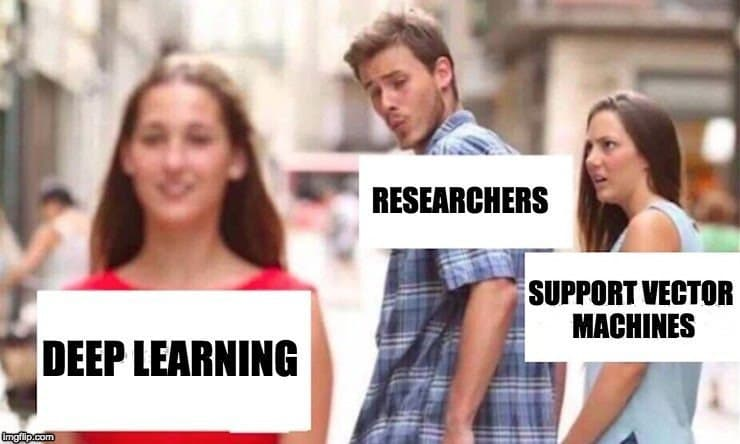

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

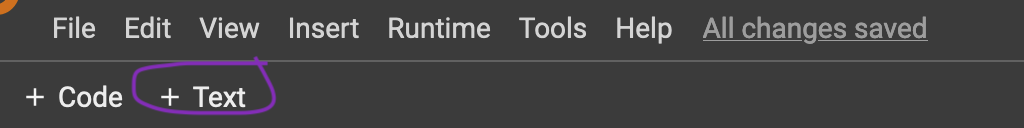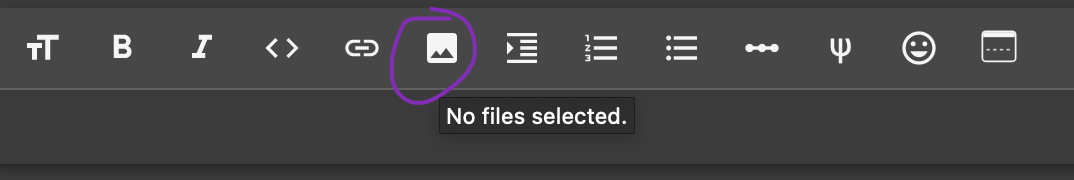

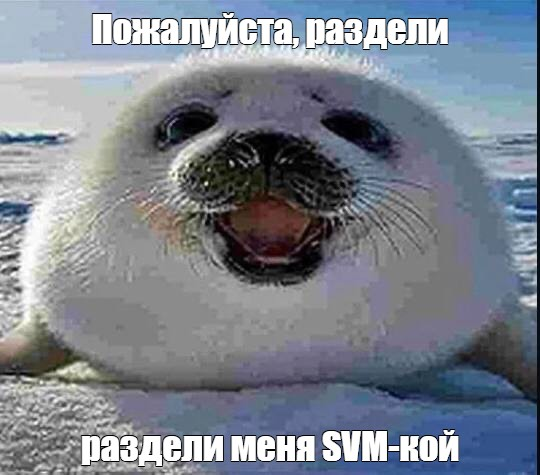